In [1]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sb
import json
import platform
import mediapipe as mp


from eye_tracker_dataset import EyeTrackerDataset
import sys

sys.path.append("..")
from eye_tracker_auto_labeller.scripts import mediapipe_visualizer

mp_face_mesh = mp.solutions.face_mesh

def edge_list_2_path(edge_list) :
    tesel = edge_list
    change_occured = True
    while change_occured :
        change_occured = False
        for idx in range(len(tesel)) :
            target_edge = tesel[idx]
            inner_changed = False
            for e in tesel :
                if e != target_edge and len(e) < 3 :
                    edge = e
                    if target_edge[-1] == edge[0] :
                        target_edge.append(edge[-1])
                        tesel.remove(edge)
                        change_occured = True
                        inner_changed = True
                        break
                    if target_edge[0] == edge[-1] :
                        target_edge.insert(0, edge[0])
                        tesel.remove(edge)
                        change_occured = True
                        inner_changed  = True
                        break
            if inner_changed :
                break
    change_occured = True
    while change_occured :
        change_occured = False
        for idx in range(len(tesel)) :
            source_path = tesel[idx]
            inner_changed = False
            for target_path in tesel :
                if target_path == source_path :
                    continue
                if source_path[-1] == target_path[-1] :
                    target_path.reverse()
                    source_path += target_path[1:]
                    tesel.remove(target_path)
                    change_occured = True
                    inner_changed = True
                    break
                if source_path[0] == target_path[0] :
                    source_path.reverse()
                    target_path += source_path[1:]
                    tesel.remove(source_path)
                    change_occured = True
                    inner_changed = True
                    break
            if inner_changed :
                break
    return tesel


FACE_TESSELATION_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_TESSELATION
)).tolist())
FACE_OVAL_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_FACE_OVAL
)).tolist())
FACE_LIPS_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_LIPS
)).tolist())
FACE_LEFT_EYEBROW_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_LEFT_EYEBROW
)).tolist())
FACE_LEFT_EYE_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_LEFT_EYE
)).tolist())
FACE_LEFT_IRIS_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_LEFT_IRIS
)).tolist())
FACE_RIGHT_EYEBROW_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_RIGHT_EYEBROW
)).tolist())
FACE_RIGHT_EYE_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_RIGHT_EYE
)).tolist())
FACE_RIGHT_IRIS_PATH_LIST = edge_list_2_path(np.array(list(
    mp_face_mesh.FACEMESH_RIGHT_IRIS
)).tolist())

def torch_to_numpy(torch_img) :
    return (torch_img.permute([1, 2, 0]).numpy() * 255).astype(np.uint8)

def convert2imagecoord(image, array, array_idx_list) :
    image_shape = np.array([image.shape[1], image.shape[0]])
    return (array[array_idx_list][:,  :2] * image_shape).astype(int)

SYSTEM_NAME = platform.system()
if SYSTEM_NAME == "Windows" :
    DATA_ROOT_PATH = "D:/data"
if SYSTEM_NAME == "Darwin" :
    DATA_ROOT_PATH = "../eye_tracker_auto_labeller/data/"


eye_tracker_dataset = EyeTrackerDataset(data_root_path=DATA_ROOT_PATH, return_landmark=False)
eye_tracker_dataset_with_landmark = EyeTrackerDataset(data_root_path=DATA_ROOT_PATH)
eye_tracker_dataset_full = EyeTrackerDataset(data_root_path=DATA_ROOT_PATH, return_image =True)

two_D_visualizer = mediapipe_visualizer.TwoDimensionVisualizer()

print(len(eye_tracker_dataset))


9513


[162, 21, 54, 103, 67, 109, 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162]


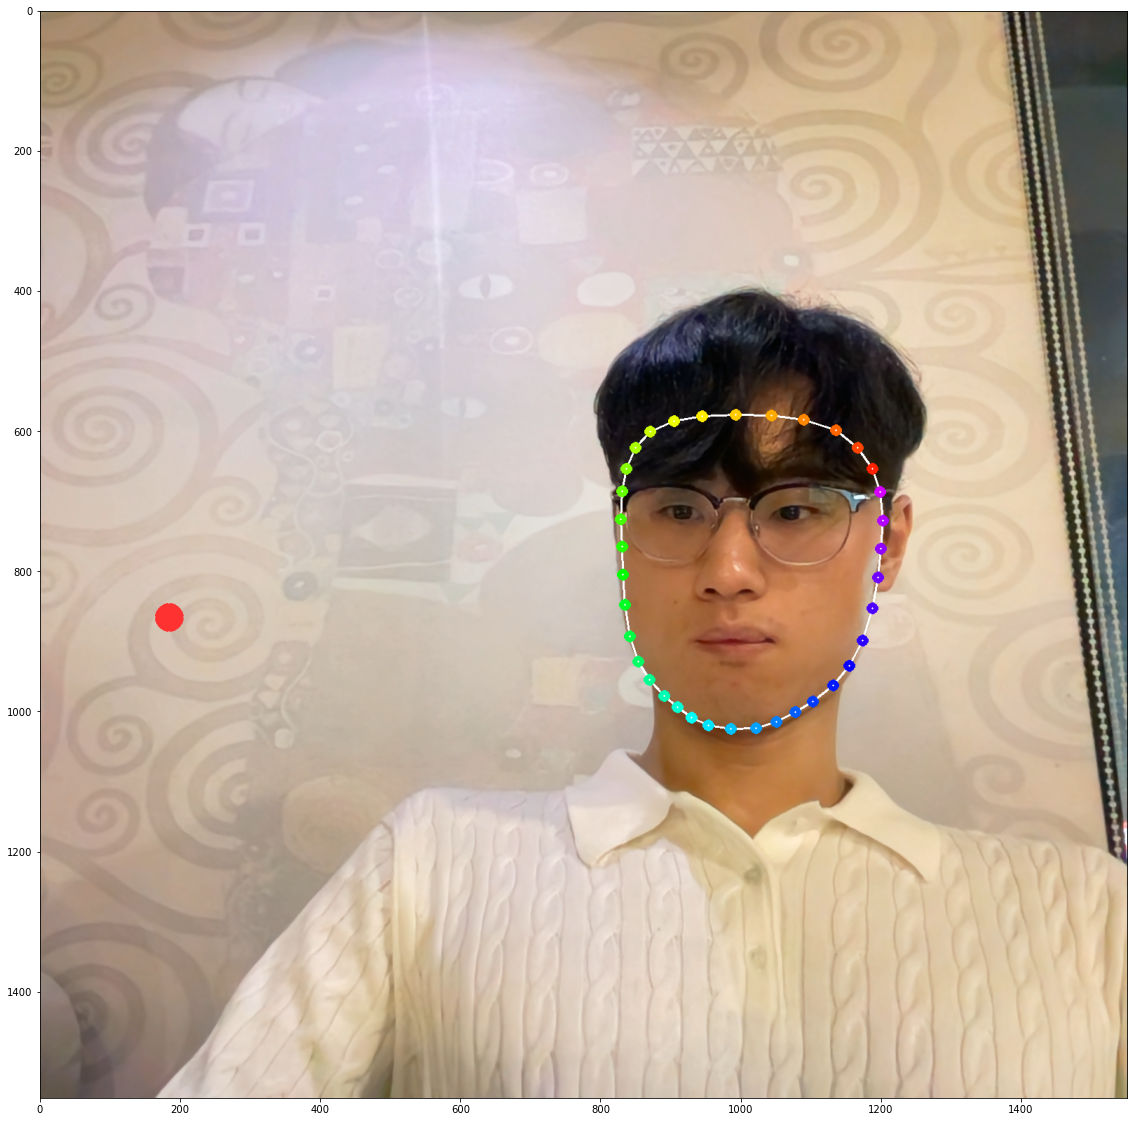

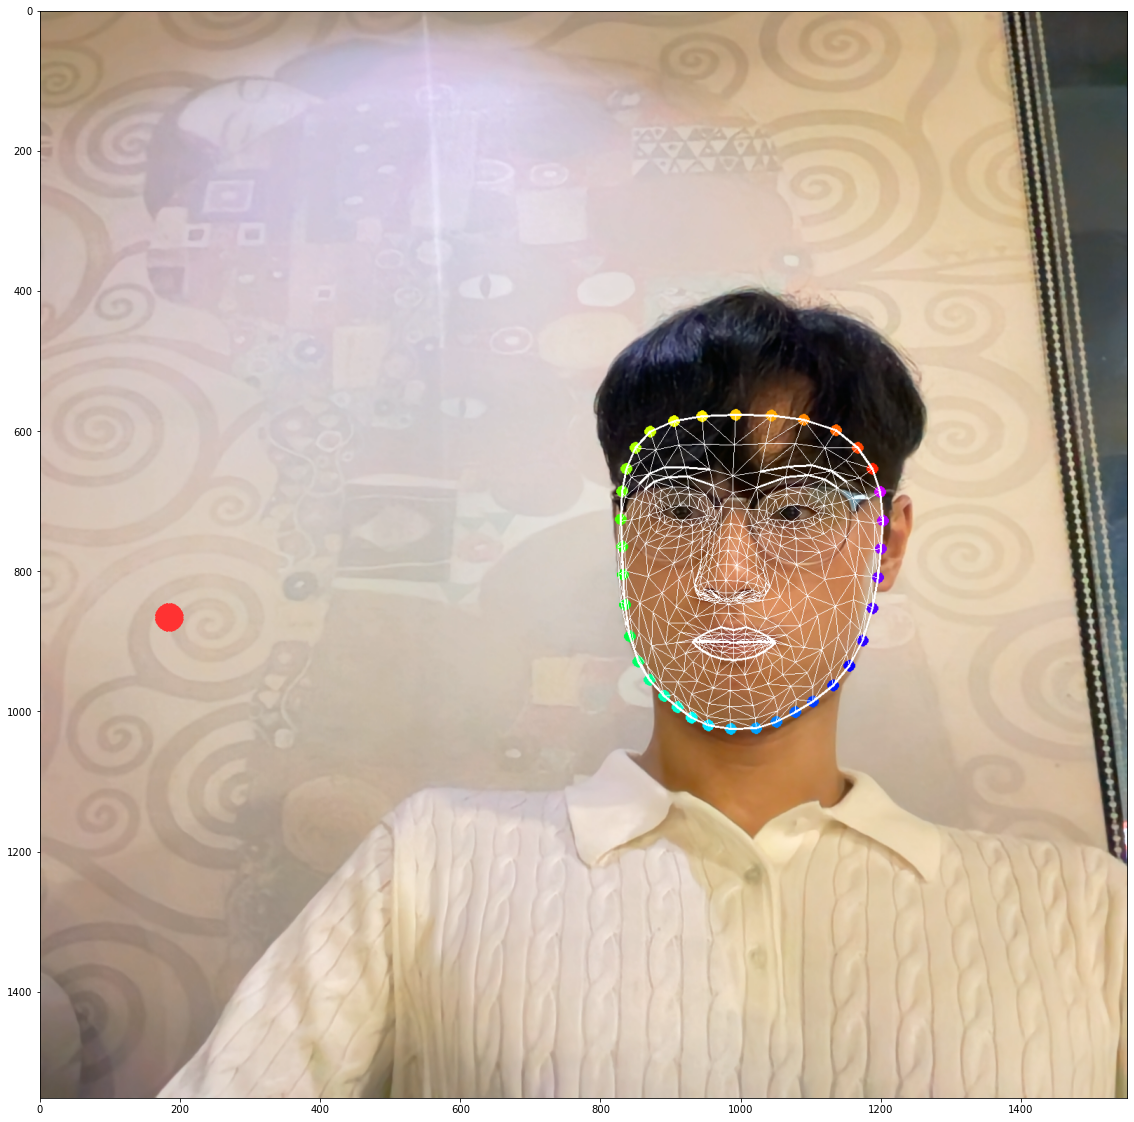

In [2]:
IDX = 9100
LIST_IDX_TO_LOOK = FACE_RIGHT_EYE_PATH_LIST[0]
LIST_IDX_TO_LOOK = FACE_RIGHT_IRIS_PATH_LIST[0]
LIST_IDX_TO_LOOK = FACE_LEFT_IRIS_PATH_LIST[0]
LIST_IDX_TO_LOOK = FACE_LEFT_EYE_PATH_LIST[0]
LIST_IDX_TO_LOOK = FACE_OVAL_PATH_LIST[0]#[6:25]

print(LIST_IDX_TO_LOOK)

data = eye_tracker_dataset_full[IDX]

face_landmark_array = data["face_landmark_array"].numpy()
full_image = torch_to_numpy(data["image"])
image_shape = np.array([full_image.shape[1], full_image.shape[0]])
mouse_position_raw = data["mouse_position"].numpy()
mouse_position = (mouse_position_raw * image_shape).astype(int)

vis_image = full_image.copy()

cv2.polylines(
    vis_image,
    [
        convert2imagecoord(full_image, face_landmark_array, LIST_IDX_TO_LOOK),
    ],
    isClosed=False,
    color=(255,255,255),
    thickness=2
)

list(map(
    lambda pos, list_idx : cv2.circle(
        vis_image,
        tuple(pos),
        5,
        tuple(
            cv2.cvtColor(
                np.uint8(
                    [int(150 * (list_idx / len(LIST_IDX_TO_LOOK))), 255, 255]
                ).reshape(1, 1, 3),
                cv2.COLOR_HSV2RGB
            )[0][0].tolist()
        ),
        5
    ),
    convert2imagecoord(full_image, face_landmark_array, LIST_IDX_TO_LOOK),
    range(len(LIST_IDX_TO_LOOK))
))


cv2.circle(
    vis_image,
    tuple(mouse_position),
    10,
    (255, 50, 50),
    20
)

plt.figure(figsize=(20, 20))
plt.imshow(vis_image)
plt.show()

two_D_visualizer.visualizeFace2D(
    vis_image,
    face_landmark_array
)

plt.figure(figsize=(20, 20))
plt.imshow(vis_image)
plt.show()


In [6]:
FACE_IDX_LIST = FACE_OVAL_PATH_LIST[0][6:] + FACE_OVAL_PATH_LIST[0][1:6]

diff_vec = np.array(list(map(
    lambda idx : face_landmark_array[FACE_IDX_LIST[-(idx + 1)]] - face_landmark_array[FACE_IDX_LIST[idx + 1]],
    range(len(FACE_IDX_LIST) // 2 - 1)
)))

diff_vec_normalized = diff_vec / np.sqrt(np.sum(diff_vec * diff_vec, axis=1)).reshape(-1, 1)

np.matmul(diff_vec_normalized, diff_vec_normalized.T)

array([[0.99999994, 0.99997795, 0.9999677 , 0.9999256 , 0.999884  ,
        0.99985415, 0.99982744, 0.9997874 , 0.9997685 , 0.9997025 ,
        0.9996088 , 0.9994776 , 0.99927086, 0.9989049 , 0.99861926,
        0.9983411 , 0.998305  ],
       [0.99997795, 1.        , 0.9999966 , 0.9999746 , 0.9999423 ,
        0.9999133 , 0.9998887 , 0.99985623, 0.99982506, 0.99975693,
        0.999667  , 0.9995309 , 0.99929297, 0.99893105, 0.99865025,
        0.9983809 , 0.9983193 ],
       [0.9999677 , 0.9999966 , 0.99999994, 0.99998933, 0.99996656,
        0.999944  , 0.99992406, 0.9998969 , 0.9998699 , 0.99980986,
        0.99972945, 0.9996046 , 0.99937946, 0.9990388 , 0.99877244,
        0.99851614, 0.99845326],
       [0.9999256 , 0.9999746 , 0.99998933, 1.0000001 , 0.9999934 ,
        0.9999806 , 0.9999678 , 0.9999501 , 0.99992645, 0.99987787,
        0.9998122 , 0.9997028 , 0.99948925, 0.99918056, 0.9989364 ,
        0.9987012 , 0.9986308 ],
       [0.999884  , 0.9999423 , 0.99996656, 0.999993